In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
import numpy as np

import optuna
# Create and optimize the study
from optuna.samplers import NSGAIISampler

# Data

In [2]:
minute_data=pd.read_excel("data_minute.xlsx")
daily_data=pd.read_excel("data_daily.xlsx")
minute5_data=pd.read_excel("data_5minute.xlsx")

In [3]:
#Set the 'Datetime' column as the index
daily_data["Datetime"] = pd.to_datetime(daily_data["Datetime"])
daily_data.set_index('Datetime', inplace=True)
minute_data['Datetime'] = pd.to_datetime(minute_data['Datetime'])
minute_data.set_index('Datetime', inplace=True)

minute5_data['Datetime'] = pd.to_datetime(minute5_data['Datetime'])
minute5_data.set_index('Datetime', inplace=True)

In [4]:
# Define the split dates
split_date_train = datetime.strptime("2021-12-31", "%Y-%m-%d")  # Last date for training
split_date_split_start = datetime.strptime("2022-01-01", "%Y-%m-%d")  # Start of split/validation
split_date_split_end = datetime.strptime("2022-12-31", "%Y-%m-%d")  # End of split/validation

# Create the train, split (validation), and test datasets
daily_is = daily_data[daily_data.index <= split_date_train].copy()  # Training set
daily_val = daily_data[(daily_data.index >= split_date_split_start) & (daily_data.index <= split_date_split_end)].copy()  # Validation set
daily_os = daily_data[daily_data.index > split_date_split_end].copy()  # Testing set




In [5]:

# Define the split dates
split_date_test = datetime.strptime("2023-12-31 14:45:00", "%Y-%m-%d %H:%M:%S")  # Start of test set
split_date_val_start = datetime.strptime("2023-06-30 14:45:00", "%Y-%m-%d %H:%M:%S")  # Start of validation set

# Create the train, split (validation), and test datasets
minute5_is = minute5_data[minute5_data.index < split_date_val_start].copy()  # Training set
minute5_val = minute5_data[(minute5_data.index >= split_date_val_start) & (minute5_data.index < split_date_test)].copy()  # Validation set
minute5_os = minute5_data[minute5_data.index >= split_date_test].copy()  # Testing set


# Helper Function

## For Strategies

In [6]:
def bollinger_band(data, window=20, stdev=2):
    data["Middle"] = data["Close"].rolling(window).mean().shift(1)
    data["Std"] = data["Close"].rolling(window).std().shift(1)
    data["Upper"] = data["Middle"].copy() + stdev * data["Std"].copy()  
    data["Lower"] = data["Middle"].copy() - stdev * data["Std"].copy()  
    return data.dropna()


In [7]:
def sma(data, window=10):
    data[f"SMA_{window}"] = data["Close"].rolling(window).mean().shift(1)
    return data.dropna()

In [8]:
def volatily(data, window=60,trading_days=252):
    data[f"Volatility"] = data["Close"].pct_change().rolling(window).std().shift(1)*math.sqrt(trading_days)
    return data.dropna()

In [9]:
def get_data(data,bb_window,bb_std,sma_window,vol_window):
    data=bollinger_band(data,bb_window,bb_std)
    data=sma(data,sma_window)
    data=volatily(data,vol_window)
    return data.dropna()

## For Execution

In [10]:
def open_position(position_type, entry_point, holdings, trade_records, date, contracts, fee_=0.001):
    """
    Opens a position and adds it to holdings. Logs the trade in trade_records.
    A transaction fee is applied during entry.

    Args:
        position_type (str): 'LONG' or 'SHORT'.
        entry_point (float): Entry price for the position.
        holdings (list): List of current open positions.
        trade_records (list): List of trade records.
        date (datetime): The date of the trade.
        contracts (int): Number of contracts for the position.
        fee_ (float): Transaction fee as a fraction (default: 0.001 or 0.1%).

    Returns:
        holdings (list): Updated holdings.
        trade_records (list): Updated trade records.
    """
    # Transaction fee
    fee = fee_ * contracts * entry_point / 10

    # Record the trade details
    trade_records.append({
        "date": date,
        "type": position_type,
        "entry_point": entry_point,
        "exit_point": None,
        "pnl": None,  # Placeholder for realized profit/loss
        "fee": fee,
        "exit_date": None,
        "contracts": contracts
    })

    # Add the position to holdings
    max_min_price = entry_point  # Initialize max/min price to entry point
    holdings.append([position_type, entry_point, max_min_price, fee, contracts])

    return holdings, trade_records


In [11]:
def close_positions(cur_price, holdings, trade_records, date, cut_loss_thres, cut_loss_max=2):
    total_realized_pnl = 0
    total_unrealized_pnl = 0

    for position in holdings[:]:
        position_type, entry_point, max_min_price, entry_fee, contracts = position

        # Update max/min price and calculate unrealized P&L
        if position_type == 'LONG':
            max_min_price = max(max_min_price, cur_price)
            unrealized_pnl = (cur_price - entry_point) * contracts / 10
            stop_loss_price = max_min_price - cut_loss_thres * max_min_price
        elif position_type == 'SHORT':
            max_min_price = min(max_min_price, cur_price)
            unrealized_pnl = (entry_point - cur_price) * contracts / 10
            stop_loss_price = max_min_price + cut_loss_thres * max_min_price

        # Check stop-loss/take-profit
        if (
            (position_type == 'LONG' and cur_price <= stop_loss_price)
            or (position_type == 'SHORT' and cur_price >= stop_loss_price)
        ):
            realized_pnl = unrealized_pnl
            realized_pnl -= entry_fee

            # Update trade record
            for record in trade_records:
                if (
                    record["type"] == position_type
                    and record["entry_point"] == entry_point
                    and record["exit_point"] is None
                ):
                    record["exit_point"] = cur_price
                    record["pnl"] = realized_pnl
                    record["fee"] = entry_fee
                    record["exit_date"] = date
                    record["contracts"] = contracts
                    record["total_pnl"] = realized_pnl
                    break

            holdings.remove(position)
            total_realized_pnl += realized_pnl
        else:
            position[2] = max_min_price
            total_unrealized_pnl += unrealized_pnl

    return holdings, trade_records, total_realized_pnl, total_unrealized_pnl


In [12]:
def contract_number(data, asset_value, cur_date, cur_price, prev_contract, margincall=0.17, initial_margin=0.25, normal_margin=0.35, volatility=0.30, vol_target=True):
    """
    Dynamically calculates the number of contracts based on margin and asset value.
    """
    normal_contract = math.floor(asset_value / (cur_price * normal_margin)*10)
    max_contract = math.floor(asset_value / (cur_price * initial_margin)*10)

    while asset_value <= margincall * cur_price * prev_contract:
        prev_contract -= 1

    if vol_target:
        vol_adjusted_contracts = math.floor(
            asset_value * data['Volatility'].loc[cur_date] / volatility
        )
        number_contract = min(max_contract, vol_adjusted_contracts)
    else:
        number_contract = max_contract

    return max(prev_contract, number_contract)


# Strategy

In [13]:
def execute_trading_strategy_1(
    trading_data_, bb_window, bb_std, sma_window, vol_window, asset_value, cut_loss_thres,
    margincall, initial_margin, normal_margin, volatility, vol_target,cut_loss_max=2
):
    trading_data = get_data(trading_data_.copy(), bb_window=bb_window, bb_std=bb_std, sma_window=sma_window, vol_window=vol_window)
    prev_date = None
    holdings=[]
    trade_records=[]
    details = []
    asset_tracking = []  # Track total asset, asset in trading, and cash
    prev_contract = 0  # Initialize contracts to zero

    # Flags to track entry conditions
    below_lower_flag = False
    above_upper_flag = False

    for date in trading_data.index:
        if prev_date is None:
            prev_date = date
            continue

        cur_price = trading_data['Close'][date]

        # Close positions and update asset
        holdings, trade_records, total_realized_pnl, total_unrealized_pnl = close_positions(
            cur_price, holdings, trade_records, date, cut_loss_thres,cut_loss_max
        )
        asset_value += total_realized_pnl  # Update realized P&L only

        # Dynamically adjust contracts
        prev_contract = contract_number(
            trading_data, asset_value, date, cur_price, prev_contract,
            margincall=margincall, initial_margin=initial_margin, normal_margin=normal_margin,
            volatility=volatility, vol_target=vol_target
        )

        # Calculate asset in trading and cash
        asset_in_trading = prev_contract * initial_margin * cur_price / 10
        cash = asset_value - asset_in_trading

        # Track assets
        asset_tracking.append({
            "date": date,
            "total_asset": asset_value,
            "asset_in_trading": asset_in_trading,
            "cash": cash
        })

        # Update asset history in the DataFrame
        trading_data.loc[date, 'Asset'] = asset_value

        # Retrieve values for trading signals
        prev_price = trading_data['Close'][prev_date]
        prev_upper = trading_data['Upper'][prev_date]
        prev_lower = trading_data['Lower'][prev_date]
        cur_price = trading_data['Close'][date]
        cur_upper = trading_data['Upper'][date]
        cur_lower = trading_data['Lower'][date]
        cur_sma = trading_data[f"SMA_{sma_window}"][date]

        # Update flags
        if cur_price <= cur_lower:
            below_lower_flag = True
        elif cur_price >= cur_upper:
            above_upper_flag = True

        # Open positions
        if below_lower_flag and cur_price >= cur_sma:
            if holdings and any(h[0] == 'SHORT' for h in holdings):
                holdings = []
            if len(holdings) == 0:
                holdings, trade_records = open_position('LONG', cur_price, holdings, trade_records, date, prev_contract)
                below_lower_flag = False
        elif above_upper_flag and cur_price <= cur_sma:
            if holdings and any(h[0] == 'LONG' for h in holdings):
                holdings = []
            if len(holdings) == 0:
                holdings, trade_records = open_position('SHORT', cur_price, holdings, trade_records, date, prev_contract)
                above_upper_flag = False

        # Log details
        current_signal = [h[0] for h in holdings]
        entry_prices = [h[1] for h in holdings]
        unrealized_pnls = [
            (cur_price - ep if sig == 'LONG' else ep - cur_price) * contracts / 10
            for sig, ep, _, _, contracts in holdings
        ]
        unrealized_pnl_total = sum(unrealized_pnls)

        details.append({
            "date": date,
            "asset": asset_value + unrealized_pnl_total,  # Include unrealized P&L correctly
            "current_signal": current_signal if holdings else None,
            "entry_price": entry_prices if holdings else None,
            "current_price": cur_price,
            "unrealized_pnl": unrealized_pnl_total,
            "contracts": prev_contract,
        })

        prev_date = date
        if asset_value < 0:
            break

    # Asset DataFrame
    asset_df = pd.DataFrame(asset_tracking)

    return trading_data.dropna(), pd.DataFrame(details), asset_df, holdings, pd.DataFrame(trade_records)


In [14]:
def execute_trading_strategy_2(
    trading_data_, lookback_period,upbound,downbound,sma_window, asset_value, cut_loss_thres,
    margincall, initial_margin, normal_margin, volatility, vol_target,cut_loss_max=2
):
    # Calculate rolling returns
    trading_data = volatily(sma(trading_data_.copy(), sma_window))
    
    trading_data['Rolling_Return'] = trading_data['Close'].pct_change(lookback_period).shift(1)
    
    prev_date = None
    details = []
    asset_tracking = []
    holdings=[]
    trade_records=[]  # Track total asset, asset in trading, and cash
    prev_contract = 0  # Initialize contracts to zero

    for date in trading_data.index:
        if prev_date is None:
            prev_date = date
            continue

        cur_price = trading_data['Close'][date]
        cur_sma = trading_data[f"SMA_{sma_window}"][date]
        # Close positions and update asset
        holdings, trade_records, total_realized_pnl, total_unrealized_pnl = close_positions(
            cur_price, holdings, trade_records, date, cut_loss_thres,cut_loss_max
        )
        asset_value += total_realized_pnl  # Update realized P&L only

        # Dynamically adjust contracts
        prev_contract = contract_number(
            trading_data, asset_value, date, cur_price, prev_contract,
            margincall=margincall, initial_margin=initial_margin, normal_margin=normal_margin,
            volatility=volatility, vol_target=vol_target
        )

        # Calculate asset in trading and cash
        asset_in_trading = prev_contract * initial_margin * cur_price / 10
        cash = asset_value - asset_in_trading

        # Track assets
        asset_tracking.append({
            "date": date,
            "total_asset": asset_value,
            "asset_in_trading": asset_in_trading,
            "cash": cash
        })

        # Update asset history in the DataFrame
        trading_data.loc[date, 'Asset'] = asset_value

        # Retrieve the rolling return
        rolling_return = trading_data['Rolling_Return'][date]

        # TSMOM Logic: Open Long if Rolling Return is Positive
        if rolling_return > upbound and cur_price > cur_sma:
            if holdings and any(h[0] == 'SHORT' for h in holdings):
                holdings = []  # Close any SHORT positions
            if len(holdings) == 0:
                holdings, trade_records = open_position('LONG', cur_price, holdings, trade_records, date, prev_contract)

        # TSMOM Logic: Open Short if Rolling Return is Negative
        elif rolling_return < downbound and cur_price < cur_sma:
            if holdings and any(h[0] == 'LONG' for h in holdings):
                holdings = []  # Close any LONG positions
            if len(holdings) == 0:
                holdings, trade_records = open_position('SHORT', cur_price, holdings, trade_records, date, prev_contract)

        # Log details
        current_signal = [h[0] for h in holdings]
        entry_prices = [h[1] for h in holdings]
        unrealized_pnls = [
            (cur_price - ep if sig == 'LONG' else ep - cur_price) * contracts / 10
            for sig, ep, _, _, contracts in holdings
        ]
        unrealized_pnl_total = sum(unrealized_pnls)

        details.append({
            "date": date,
            "asset": asset_value + unrealized_pnl_total,  # Include unrealized P&L correctly
            "current_signal": current_signal if holdings else None,
            "entry_price": entry_prices if holdings else None,
            "current_price": cur_price,
            "rolling_return": rolling_return,
            "unrealized_pnl": unrealized_pnl_total,
            "contracts": prev_contract,
        })

        prev_date = date
        if asset_value < 0:
            break

    # Asset DataFrame
    asset_df = pd.DataFrame(asset_tracking)

    return trading_data.dropna(), pd.DataFrame(details), asset_df, holdings, pd.DataFrame(trade_records)



# Optimization

## Helper function

In [15]:
def calculate_metrics(ts,rfrate=.05,trading_day=252):
    """
    Calculate the Sharpe ratio for a time series of returns.
    """
    start=ts.index.min()
    start = start.strftime('%Y-%m-%d')
    end=ts.index.max()
    end = end.strftime('%Y-%m-%d')

    ts=ts.astype(float)
    

    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    time_length=(datetime.strptime(end, '%Y-%m-%d')-datetime.strptime(start, '%Y-%m-%d')).days/365.25
    cum_rets=(1+ts).cumprod()
    mean_stock_return = cum_rets.iloc[-1].item()**(1/time_length)-1

    ######################### COMPUTE THE SHARPE ################################
    mean = mean_stock_return
    std = ts.std().item() * np.sqrt(trading_day)
    sharpe = (mean-rfrate)/std
    
    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)
    min_drawdon = -drawdown.min().item()

    return sharpe, min_drawdon

## Optimize Daily

In [16]:
def objective_daily_2(trial):
    # Main
    try: 
        asset_value = 1000  # Initial capital (1B)
        fee = 0.001  # Transaction fee (0.1%)
        margin_call = 0.17  # Margin call threshold
        initial_margin = 0.25  # Initial margin requirement
        cut_loss_max=3
        # Strategy 2 Parameters
        cut_loss_thres_2 = trial.suggest_float('cut_loss_thres_2', 0.0075, 0.02)
        lookback_period = trial.suggest_int("lookback_period", 10, 50)
        upbound = trial.suggest_float("upbound", 0, lookback_period/60*0.25/100)
        downbound = trial.suggest_float("downbound", -lookback_period/60*0.25/100, 0)
        sma_window_2 = trial.suggest_int("sma_window_2", 3, lookback_period/2)
        normal_margin_2 = trial.suggest_float("normal_margin_2", 0.2, 0.5)
        vol_target_2 = trial.suggest_categorical("vol_target_2", [True, False])
        volatility_2 = trial.suggest_float("volatility_2", 0.15, 0.50)

        # Execute Strategy 2 on IS Data
        result_2, _, _, _, _ = execute_trading_strategy_2(
            daily_is, lookback_period, upbound,downbound, sma_window_2, asset_value,
            cut_loss_thres_2, margin_call, initial_margin, normal_margin=normal_margin_2,
            volatility=volatility_2, vol_target=vol_target_2,cut_loss_max=cut_loss_max
        )
        
        

        # Execute Strategy 2 on OOS Data
        result_val2, _, _, _, _ = execute_trading_strategy_2(
            daily_val, lookback_period, upbound,downbound, sma_window_2, asset_value,
            cut_loss_thres_2, margin_call, initial_margin, normal_margin=normal_margin_2,
            volatility=volatility_2, vol_target=vol_target_2,cut_loss_max=cut_loss_max
        )
        result_os2, _, _, _, _ = execute_trading_strategy_2(daily_os
            , lookback_period, upbound,downbound, sma_window_2, asset_value,
            cut_loss_thres_2, margin_call, initial_margin, normal_margin=normal_margin_2,
            volatility=volatility_2, vol_target=vol_target_2   ,cut_loss_max=cut_loss_max)

        returns_2 = result_2["Asset"].pct_change().dropna()
        daily_returns_is = returns_2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
        sharpe_is, drawdown_is = calculate_metrics(daily_returns_is)
        returns_val2 = result_val2["Asset"].pct_change().dropna()
        daily_returns_val = returns_val2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
        sharpe_val, drawdown_val = calculate_metrics(daily_returns_val)
        returns_os2 = result_os2["Asset"].pct_change().dropna()
        daily_returns_os = returns_os2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
        sharpe_os, drawdown_os = calculate_metrics(daily_returns_os)
        # Sharpe Difference
        sharpe_diff =sharpe_is - sharpe_val  # Absolute difference for similarity
        sharpe_diff2 =sharpe_is - sharpe_os  # Absolute difference for similarity
        # Penalty Calculation
        sharpe_diff_max = 0.5  # Maximum acceptable Sharpe difference
        max_drawdown = 0.5  # Maximum acceptable drawdown

        penalty = 0
        penalty += 50 * max(0, sharpe_diff - sharpe_diff_max)  # Penalize large Sharpe difference
        penalty += 200 * max(0, drawdown_is - max_drawdown)  # Penalize high drawdown

        # Objective Metric
        objective_value = sharpe_is - penalty
        trial.set_user_attr("sharpe_diff2", sharpe_diff2)
        trial.set_user_attr("sharpe_is", sharpe_is)
    except Exception as e:
        # Handle exceptions during trial execution (e.g., due to invalid parameters)
        return float("-inf")
    
    return objective_value, drawdown_is, sharpe_diff

In [17]:
# # Use NSGA-II for multi-objective optimization
# sampler = NSGAIISampler()
# study = optuna.create_study(directions=["maximize","minimize","minimize"], sampler=sampler)
# study.optimize(objective_daily_2, n_trials=5000)
# # Collect results into a pandas DataFrame
# results_daily_2 = []
# for trial in study.trials:
#     results_daily_2.append({
#         "Trial Number": trial.number,
#         "Objective Value": trial.values[0],
#         "Sharpe": trial.user_attrs.get("sharpe_is"),
#         "Drawndown": trial.values[1],
#         "IS-VAL Difference": trial.values[2],
#         "IS-OS Difference": trial.user_attrs.get("sharpe_diff2"),              
#         **trial.params                   # Unpack trial parameters
#     })

# # Convert results to DataFrame
# results_daily_2 = pd.DataFrame(results_daily_2)
# # Save to CSV
# output_file = "strategy_2_dauly_final.csv"
# results_daily_2.to_csv(output_file, index=False)

# print(f"Results saved to {output_file}")

In [18]:
def objective_daily_1(trial):
    # Main setup
    asset_value = 1000  # Initial capital (1B)
    fee = 0.001  # Transaction fee (0.1%)

    #Strategy 2
    cut_loss_thres_2 = .0096
    normal_margin_2=0.44
    lookback_period=29
    upbound=0.0007
    downbound=-0.0002
    sma_window_2=7
    volatility_2=.44
    vol_target_2 = True

    # Execute Strategy 2 on IS and OOS data
    results_is2, _, _, _, _ = execute_trading_strategy_2(
        daily_is, lookback_period, upbound, downbound, sma_window_2, asset_value,
        cut_loss_thres_2, 0.17, 0.25, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    results_val2, _, _, _, _ = execute_trading_strategy_2(
        daily_val, lookback_period, upbound, downbound, sma_window_2, asset_value,
        cut_loss_thres_2, 0.17, 0.25, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    results_os2, _, _, _, _ = execute_trading_strategy_2( daily_os, lookback_period, upbound, downbound, sma_window_2, asset_value,
        cut_loss_thres_2, 0.17, 0.25, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    # Strategy 1: Parameters to Optimize
    bb_window = trial.suggest_int("bb_window", 5, 50)
    sma_window = trial.suggest_int("sma_window", 1, bb_window/3)
    bb_std = trial.suggest_float("bb_std", .5, 3.5)
    vol_window = 60
    cut_loss_thres_1 = trial.suggest_float('cut_loss_thres', 0.0075, 0.02)
    normal_margin_1 = trial.suggest_float("normal_margin", 0.2, 0.5)
    volatility_1 = trial.suggest_float("volatility", 0.25, 0.45)
    vol_target_1 = trial.suggest_categorical("vol_target", [True, False])
    weight_1 = trial.suggest_float("weight_1", 0.15, 0.85)

    # Execute Strategy 1 on IS Data
    results_is1, _, _, _, _ = execute_trading_strategy_1(
        daily_is, bb_window, bb_std, sma_window, vol_window, asset_value,
        cut_loss_thres_1, margincall=0.17, initial_margin=0.25, normal_margin=normal_margin_1,
        volatility=volatility_1, vol_target=vol_target_1
    )
    
    # Execute Strategy 1 on OOS Data
    results_val1, _, _, _, _ = execute_trading_strategy_1(
        daily_val, bb_window, bb_std, sma_window, vol_window, asset_value,
        cut_loss_thres_1, margincall=0.17, initial_margin=0.25, normal_margin=normal_margin_1,
        volatility=volatility_1, vol_target=vol_target_1
    )
    results_os1, _, _, _, _ = execute_trading_strategy_1(daily_os, bb_window, bb_std, sma_window, vol_window, asset_value,
        cut_loss_thres_1, margincall=0.17, initial_margin=0.25, normal_margin=normal_margin_1,
        volatility=volatility_1, vol_target=vol_target_1
    )

    returns_is1 = results_is1["Asset"].pct_change().dropna()
    returns_is2=results_is2["Asset"].pct_change().dropna()
    daily_return_is1=returns_is1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    daily_return_is2=returns_is2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()

    returns_os1 = results_os1["Asset"].pct_change().dropna()
    returns_os2 = results_os2["Asset"].pct_change().dropna()
    daily_return_os1=returns_os1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    daily_return_os2=returns_os2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()

    returns_val1=results_val1["Asset"].pct_change().dropna()
    daily_return_val1=returns_val1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    returns_val2=results_val2["Asset"].pct_change().dropna()
    daily_return_val2=returns_val2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()

     # Combine IS Returns (Strategy 1 and 2)
    returns_is_combined = daily_return_is1 * weight_1 + daily_return_is2 * (1 - weight_1)
    sharpe_is, drawdown_is = calculate_metrics(returns_is_combined)
    # Combine OOS Returns (Strategy 1 and 2)
    returns_os_combined = daily_return_os1 * weight_1 + daily_return_os2 * (1 - weight_1)
    sharpe_os, drawdown_os = calculate_metrics(returns_os_combined)
    # Combine VAL Returns (Strategy 1 and 2)
    returns_val_combined = daily_return_val1 * weight_1 + daily_return_val2 * (1 - weight_1)
    sharpe_val,drawdown_val=calculate_metrics(returns_val_combined)

    # Sharpe Difference
    sharpe_diff_is_val=sharpe_is - sharpe_val  # Absolute difference for similarity
    sharpe_diff_is_os = sharpe_is - sharpe_os  # Absolute difference for similarity

    # Penalty Calculation

    sharpe_diff_max = 0.8  # Maximum acceptable Sharpe difference
    max_drawdown = 0.5  # Maximum acceptable drawdown

    penalty = 0
    penalty += 50 * max(0, sharpe_diff_is_val - sharpe_diff_max)  # Penalize large Sharpe difference
    penalty += 200 * max(0, drawdown_is - max_drawdown)  # Penalize high drawdown

    # Objective Metric
    objective_value = sharpe_is - penalty
    trial.set_user_attr("sharpe_diff2", sharpe_diff_is_os)
    trial.set_user_attr("sharpe_is", sharpe_is)


    return objective_value, drawdown_is, sharpe_diff_is_val


In [19]:
# # Use NSGA-II for multi-objective optimization
# sampler = NSGAIISampler()
# study = optuna.create_study(directions=["maximize","minimize","minimize"], sampler=sampler)
# study.optimize(objective_daily_1, n_trials=2000)
# # Collect results into a pandas DataFrame
# results_daily_1 = []
# for trial in study.trials:
#     results_daily_1.append({
#         "Trial Number": trial.number,
#         "Objective Value": trial.values[0],
#         "Sharpe": trial.user_attrs.get("sharpe_is"),
#         "Drawndown": trial.values[1],
#         "IS-VAL Difference": trial.values[2],
#         "IS-OS Difference": trial.user_attrs.get("sharpe_diff2"),              
#         **trial.params                   # Unpack trial parameters
#     })

# # Convert results to DataFrame
# results_daily_1 = pd.DataFrame(results_daily_1)
# # Save to CSV
# output_file = "strategy_1_daily_final.csv"
# results_daily_1.to_csv(output_file, index=False)

# print(f"Results saved to {output_file}")

## Optimize Minute 5

In [20]:
def objective_5minute_2(trial):
    # Main
    asset_value = 1000  # Initial capital (1B)
    fee = 0.001  # Transaction fee (0.1%)
    margin_call = 0.17  # Margin call threshold
    initial_margin = 0.25  # Initial margin requirement

    # Strategy 2 Parameters
    cut_loss_thres_2 = trial.suggest_float('cut_loss_thres_2', 0.005, 0.02)
    lookback_period = trial.suggest_int("lookback_period", 10, 500)
    upbound = trial.suggest_float("upbound", 0, lookback_period/60*0.25/100)
    downbound = trial.suggest_float("downbound", -lookback_period/60*0.25/100, 0)
    sma_window_2 = trial.suggest_int("sma_window_2", 3, lookback_period)
    normal_margin_2 = trial.suggest_float("normal_margin_2", 0.2, 0.5)
    vol_target_2 = trial.suggest_categorical("vol_target_2", [True, False])
    volatility_2 = trial.suggest_float("volatility_2", 0.15, 0.50)

    # Execute Strategy 2 on IS Data
    result_2, _, _, _, _ = execute_trading_strategy_2(
        minute5_is.copy(), lookback_period, upbound,downbound, sma_window_2, asset_value,
        cut_loss_thres_2, margin_call, initial_margin, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    
    returns_2 = result_2["Asset"].pct_change().dropna()
    daily_returns_is = returns_2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    sharpe_is, drawdown_is = calculate_metrics(daily_returns_is)

    # Execute Strategy 2 on OOS Data
    result_os2, _, _, _, _ = execute_trading_strategy_2(
        minute5_val.copy(), lookback_period, upbound,downbound, sma_window_2, asset_value,
        cut_loss_thres_2, margin_call, initial_margin, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    returns_os2 = result_os2["Asset"].pct_change().dropna()
    daily_returns_os = returns_os2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    sharpe_os, drawdown_os = calculate_metrics(daily_returns_os)

    # Sharpe Difference
    sharpe_diff =sharpe_is - sharpe_os  # Absolute difference for similarity

    # Penalty Calculation
    sharpe_diff_max = 0.5  # Maximum acceptable Sharpe difference
    max_drawdown = 0.5  # Maximum acceptable drawdown

    penalty = 0
    penalty += 50 * max(0, sharpe_diff - sharpe_diff_max)  # Penalize large Sharpe difference
    penalty += 200 * max(0, drawdown_is - max_drawdown)  # Penalize high drawdown

    # Objective Metric
    objective_value = sharpe_is - penalty
    return objective_value, drawdown_is, sharpe_diff


In [21]:
# # Use NSGA-II for multi-objective optimization
# sampler = NSGAIISampler()
# study = optuna.create_study(directions=["maximize","minimize","minimize"], sampler=sampler)
# study.optimize(objective_5minute_2, n_trials=1000)


In [22]:
# # Collect results into a pandas DataFrame
# results_5min_2 = []
# for trial in study.trials:
#     results_5min_2.append({
#         "Trial Number": trial.number,
#         "Sharpe": trial.values[0],
#         "Drawndown": trial.values[1],
#         "Sharpe Difference": trial.values[2],               
#         **trial.params                   # Unpack trial parameters
#     })

# # Convert results to DataFrame
# results_5min_2 = pd.DataFrame(results_5min_2)
# # Save to CSV
# output_file = "strategy_2_5min.csv"
# results_5min_2.to_csv(output_file, index=False)

# print(f"Results saved to {output_file}")

In [23]:
def objective_minute5_1(trial):
    # Main setup
    asset_value = 1000  # Initial capital (1B)
    fee = 0.001  # Transaction fee (0.1%)

    #Strategy 2
    cut_loss_thres_2 = .009
    normal_margin_2=0.37
    lookback_period=136
    upbound=0.00264
    downbound=-0
    sma_window_2=6
    volatility_2=.39
    vol_target_2 = False

    # Execute Strategy 2 on IS and OOS data
    results_is2, _, _, _, _ = execute_trading_strategy_2(
        minute5_is.copy(), lookback_period, upbound, downbound, sma_window_2, asset_value,
        cut_loss_thres_2, 0.17, 0.25, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )
    results_os2, _, _, _, _ = execute_trading_strategy_2(
        minute5_val.copy(), lookback_period, upbound, downbound, sma_window_2, asset_value,
        cut_loss_thres_2, 0.17, 0.25, normal_margin=normal_margin_2,
        volatility=volatility_2, vol_target=vol_target_2
    )

    # Strategy 1: Parameters to Optimize
    bb_window = trial.suggest_int("bb_window", 5, 150)
    sma_window = trial.suggest_int("sma_window", 3, bb_window)
    bb_std = trial.suggest_float("bb_std", 1, 3)
    vol_window = 60
    cut_loss_thres_1 = trial.suggest_float('cut_loss_thres', 0.0075, 0.02)
    normal_margin_1 = trial.suggest_float("normal_margin", 0.2, 0.5)
    volatility_1 = trial.suggest_float("volatility", 0.25, 0.45)
    vol_target_1 = trial.suggest_categorical("vol_target", [True, False])
    weight_1 = trial.suggest_float("weight_1", 0.15, 0.85)

    # Execute Strategy 1 on IS Data
    results_is1, _, _, _, _ = execute_trading_strategy_1(
        minute5_is.copy(), bb_window, bb_std, sma_window, vol_window, asset_value,
        cut_loss_thres_1, margincall=0.17, initial_margin=0.25, normal_margin=normal_margin_1,
        volatility=volatility_1, vol_target=vol_target_1
    )
    

   

    # Execute Strategy 1 on OOS Data
    results_os1, _, _, _, _ = execute_trading_strategy_1(
        minute5_val.copy(), bb_window, bb_std, sma_window, vol_window, asset_value,
        cut_loss_thres_1, margincall=0.17, initial_margin=0.25, normal_margin=normal_margin_1,
        volatility=volatility_1, vol_target=vol_target_1
    )

    returns_is1 = results_is1["Asset"].pct_change().dropna()
    returns_is2=results_is2["Asset"].pct_change().dropna()
    daily_return_is1=returns_is1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    daily_return_is2=returns_is2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    returns_os1 = results_os1["Asset"].pct_change().dropna()
    returns_os2 = results_os2["Asset"].pct_change().dropna()
    daily_return_os1=returns_os1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
    daily_return_os2=returns_os2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
     # Combine IS Returns (Strategy 1 and 2)
    returns_is_combined = daily_return_is1 * weight_1 + daily_return_is2 * (1 - weight_1)
    sharpe_is, drawdown_is = calculate_metrics(returns_is_combined)
    # Combine OOS Returns (Strategy 1 and 2)
    returns_os_combined = daily_return_os1 * weight_1 + daily_return_os2 * (1 - weight_1)
    sharpe_os, drawdown_os = calculate_metrics(returns_os_combined)

    # Sharpe Difference
    sharpe_diff = sharpe_is - sharpe_os  # Absolute difference for similarity

    # Penalty Calculation
    sharpe_min = 1  # Minimum acceptable Sharpe ratio
    sharpe_diff_max = 0.5  # Maximum acceptable Sharpe difference
    max_drawdown = 0.5  # Maximum acceptable drawdown

    penalty = 0
    penalty += 50 * max(0, sharpe_diff - sharpe_diff_max)  # Penalize large Sharpe difference
    penalty += 200 * max(0, drawdown_is - max_drawdown)  # Penalize high drawdown

    # Objective Metric
    objective_value = sharpe_is - penalty


    return objective_value, drawdown_is, sharpe_diff


In [24]:
# # Use NSGA-II for multi-objective optimization
# sampler = NSGAIISampler()
# study = optuna.create_study(directions=["maximize","minimize","minimize"], sampler=sampler)
# study.optimize(objective_minute5_1, n_trials=1000)



In [25]:
# results_5min_1 = []
# for trial in study.trials:
#     try:
#         # Only process completed trials
#         if trial.state == optuna.trial.TrialState.COMPLETE:
#             results_5min_1.append({
#                 "Trial Number": trial.number,
#                 "Sharpe": trial.values[0],  # First objective value
#                 "Drawdown": trial.values[1],  # Second objective value
#                 "Sharpe Difference": trial.values[2],  # Third objective value
#                 **trial.params             # Unpack trial parameters
#             })
#     except Exception as e:
#         # Log the error and skip this trial
#         print(f"Error processing trial {trial.number}: {e}")
#         pass

# # Convert results to DataFrame
# results_5min_1 = pd.DataFrame(results_5min_1)

# # Save to CSV
# output_file = "strategy_1_5min.csv"
# results_5min_1.to_csv(output_file, index=False)

# print(f"Results saved to {output_file}")

In [26]:
# # Use NSGA-II for multi-objective optimization
# sampler = NSGAIISampler()
# study = optuna.create_study(directions=["maximize","minimize","minimize"], sampler=sampler)
# study.optimize(objective_minute_1, n_trials=2)

# # Collect results into a pandas DataFrame
# results_min_1 = []
# for trial in study.trials:
#     results_min_1.append({
#         "Trial Number": trial.number,
#         "Sharpe": trial.values[0],
#         "Drawndown": trial.values[1],
#         "IS-VAL Difference": trial.values[2],
                     
#         **trial.params                   # Unpack trial parameters
#     })

# # Convert results to DataFrame
# results_min_1 = pd.DataFrame(results_min_1)
# # Save to CSV
# output_file = "strategy_1_1min.csv"
# results_min_1.to_csv(output_file, index=False)

# print(f"Results saved to {output_file}")

# Backtesting 

## Helper Function

In [27]:
#Conect to database
index_query = """
    select o.datetime, o.price as op, c.price as cp
    from quote.open o join quote.close c
    on o.tickersymbol = c.tickersymbol and o.datetime = c.datetime
    where o.tickersymbol = 'VNINDEX' and o.datetime between %s and %s
    order by o.datetime
"""
# Database connection parameters
db_params = {
    "host": "api.algotrade.vn",
    "port": 5432,
    "database": "algotradeDB",
    "user": "intern_read_only",
    "password": "ZmDaLzFf8pg5"
}

connection = psycopg2.connect(**db_params)
def execute_query(query, from_date, to_date):
    cursor = connection.cursor()
    try:
        cursor.execute(query, (from_date, to_date))
        result = cursor.fetchall()

        cursor.close()
        return result

    except Exception as e:
        print(f"Error: {e}")

In [28]:
def plot_asset(trading_data):   
# plot asset value over time
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(trading_data.index, trading_data["Asset"])

    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_tick_params(rotation=45)

    plt.title("Asset")
    plt.grid(True)
    plt.show()

In [29]:
def backtest_strategy(ts, rfrate=0.05, trading_day=252, freq="D"):
    """
    -----------------------------------------------------------------------------
    | Output: Beta CAPM metric                                                  |
    -----------------------------------------------------------------------------
    | Inputs: - ts: returns of the time series                                  |
    -----------------------------------------------------------------------------
    """
    # Database connection parameters
    db_params = {
        "host": "api.algotrade.vn",
        "port": 5432,
        "database": "algotradeDB",
        "user": "intern_read_only",
        "password": "ZmDaLzFf8pg5"
    }

    connection = psycopg2.connect(**db_params)
    ts = ts.astype(float)
    start = ts.index.min().strftime('%Y-%m-%d')
    end = ts.index.max().strftime('%Y-%m-%d')

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = pd.DataFrame(execute_query(index_query, start, end), columns=["Datetime", "Open", "Close"])
    benchmark.set_index("Datetime", inplace=True)
    benchmark = benchmark.astype(float)
    ret_bench = benchmark["Close"].pct_change().dropna()
    ret_bench = ret_bench.astype(float)

    # Concat the asset and the benchmark
    join = pd.concat((ts, ret_bench), axis=1).dropna()
    join[['Asset', 'Close']] = join[['Asset', 'Close']].astype(float)

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov / var

    ######################### COMPUTE THE ALPHA #################################
    time_length = (datetime.strptime(end, '%Y-%m-%d') - datetime.strptime(start, '%Y-%m-%d')).days / 365.25
    cum_rets = (1 + ts).cumprod()
    mean_stock_return = cum_rets.iloc[-1].item()**(1 / time_length) - 1

    # Mean of returns for the market
    cum_rets_market = (1 + ret_bench).cumprod()
    mean_market_return = cum_rets_market.iloc[-1].item()**(1 / time_length) - 1

    # Alpha
    alpha = mean_stock_return - beta * mean_market_return

    ######################### COMPUTE THE SHARPE ################################
    mean = mean_stock_return
    std = ts.std().item() * np.sqrt(trading_day)
    Sharpe = (mean - rfrate) / std

    ######################### COMPUTE THE SORTINO ###############################
    downward = ts[ts < 0]
    std_downward = downward.std().item() * np.sqrt(trading_day)
    Sortino = mean / std_downward

    ######################### COMPUTE THE DRAWDOWN ###############################
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1
    drawdown = ((cum_rets) / running_max - 1)
    min_drawdown = -drawdown.min().item()

    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    n = 100000
    t = int(n * theta)
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)), columns=["Simulations"])
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]

    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t, :].mean().values[0]

    ######################### PLOT THE RESULTS #################################
    print(f"""
    Annulized Return: {np.round(mean_stock_return*100, 2)}% \t Volatility: {np.round(std*100, 2)} %\t \
    
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)}% \t 
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)}% \t CVaR: {np.round(cVaR*100, 2)}% \t 
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t Drawdown: {np.round(min_drawdown*100, 2)}%
    -----------------------------------------------------------------------------
    """)

    # Decide chart scale based on cumulative return
    log_scale = cum_rets.max().item() > 5

    plt.figure(figsize=(15, 8))
    plt.plot(cum_rets, color="#035593", linewidth=3)
    plt.plot(cum_rets_market, color="#068C72", linewidth=3)
    if log_scale:
        plt.yscale("log")
        y_ticks = [1, 2, 5, 10]
        plt.yticks(y_ticks, labels=[str(int(tick)) for tick in y_ticks])
    plt.title("CUMULATIVE RETURN", size=15)
    plt.ylabel("Cumulative return", size=15)
    plt.xticks(size=15, fontweight="bold")
    plt.yticks(size=15, fontweight="bold")
    plt.legend(["Strategy", "Benchmark"], fontsize=15)
    plt.show()

  
    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown["Asset"]*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown["Asset"]*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.show()


In [30]:
def yearly_backtest(ts, rfrate=0.05, trading_day=252):
    """
    Computes yearly performance metrics: Return, Volatility, Sharpe, Max Drawdown, Beta, Alpha, Sortino, VaR, cVaR.
    ---------------------------------------------------------------------------
    | Inputs:
    | - ts: returns of the time series (pandas Series with datetime index)
    | - rfrate: risk-free rate (default 0.05)
    | - trading_day: annualization factor (default 252)
    |
    | Output:
    | - DataFrame with yearly metrics in the order specified
    ---------------------------------------------------------------------------
    """
    # Ensure ts is a DataFrame with a single column named "Asset"
    if isinstance(ts, pd.Series):
        ts = ts.to_frame("Asset")
    else:
        ts = ts.rename(columns={ts.columns[0]: "Asset"})

    ts.index = pd.to_datetime(ts.index)  # Ensure datetime index

    # Add Year column for grouping
    ts['Year'] = ts.index.year

    yearly_metrics = []  # To store results for each year

    for year, group in ts.groupby('Year'):
        try:
            # Ensure the group is sorted by date
            group = group.sort_index()

            # Define start and end dates
            start = group.index.min()
            end = group.index.max()

            # Compute time length in years
            time_length = (end - start).days / 365.25

            # Cumulative returns
            cum_rets = (1 + group["Asset"]).cumprod()
            mean_stock_return = cum_rets.iloc[-1] ** (1 / time_length) - 1
            annualized_return = mean_stock_return

            # Annualized volatility
            volatility = group["Asset"].std() * np.sqrt(trading_day)

            # Dummy benchmark data (use a placeholder or real data)
            benchmark = pd.DataFrame({
                "Date": pd.date_range(start, end, freq='D'),
                "Close": np.cumprod(1 + np.random.normal(0, 0.01, (end - start).days + 1))
            }).set_index("Date")
            benchmark['Return'] = benchmark['Close'].pct_change().dropna()

            ret_bench = benchmark['Return']
            cum_rets_market = (1 + ret_bench).cumprod()
            mean_market_return = cum_rets_market.iloc[-1] ** (1 / time_length) - 1

            # Compute Beta
            join = pd.concat((group["Asset"], ret_bench), axis=1).dropna()
            cov = np.cov(join.iloc[:, 0], join.iloc[:, 1])[0, 1]
            var = np.var(join.iloc[:, 1])
            beta = cov / var

            # Compute Alpha
            alpha = mean_stock_return - beta * mean_market_return

            # Compute Sharpe Ratio
            sharpe = (annualized_return - rfrate) / volatility

            # Compute Sortino Ratio
            downside = group["Asset"][group["Asset"] < 0]
            std_down = downside.std() * np.sqrt(trading_day)
            sortino = annualized_return / std_down

            # Compute Max Drawdown
            running_max = cum_rets.cummax()
            drawdown = (cum_rets / running_max) - 1
            max_drawdown = drawdown.min()

            # Compute VaR and cVaR
            theta = 0.01
            simulations = np.random.normal(annualized_return, volatility, size=100000)
            var = -np.percentile(simulations, theta * 100)
            cvar = -simulations[simulations <= -var].mean()

            # Append results for the year
            yearly_metrics.append({
                'Year': year,
                'Return': annualized_return,
                'Volatility': volatility,
                'Sharpe': sharpe,
                'Max Drawdown': max_drawdown,
                'Beta': beta,
                'Alpha': alpha,
                'Sortino': sortino,
                'VaR': var,
                'cVaR': cvar
            })

        except Exception as e:
            print(f"Error processing year {year}: {e}")

    # Convert results to DataFrame
    metrics_df = pd.DataFrame(yearly_metrics)

    # Arrange columns in the specified order
    metrics_df = metrics_df[['Year', 'Return', 'Volatility', 'Sharpe', 'Max Drawdown', 
                             'Beta', 'Alpha', 'Sortino', 'VaR', 'cVaR']]
    return metrics_df


## Backtest Daily

### Execute Tradegy

In [31]:
# Input for Daily Data
#Overall
asset_value = 1000  # 10B
prev_date = None
fee=0.001 #0.1% transaction fee
#Contract number
margin_call=0.17
initial_margin=0.27
cut_loss_max=5
# Strategy 1
cut_loss_thres_1 = .0128
sma_window=12
bb_window=42
bb_std=1.23
vol_window=60
normal_margin_1=0.24
volatility_1=0.4
vol_target_1=True

#Strategy 2
cut_loss_thres_2 = .0096
normal_margin_2=0.48
lookback_period=29
upbound=0.0007
downbound=-0.0002
sma_window_2=7
volatility_2=.44
vol_target_2 = True
# Execute the trading strategy
weight_1=0.52
trading_data_is1 = daily_is.copy()
trading_data_os1=daily_os.copy()
trading_data_is2=daily_is.copy()
trading_data_os2=daily_os.copy()
trading_data_all1=daily_data.copy()
trading_data_all2=daily_data.copy()

In [32]:
# Execute for Strategy 1
result_is1, details_is1,asset_is1,holdings_is1, trade_records_is1 = execute_trading_strategy_1(
    trading_data_is1,bb_window,bb_std,sma_window,vol_window, asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)
result_os1, details_os1,asset_os1,holdings_os1, trade_records_os1 = execute_trading_strategy_1(trading_data_os1,bb_window,bb_std,sma_window,vol_window,
                                                                                                asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)
result_all1, details_all1,asset_all1,holdings_all1, trade_records_all1 = execute_trading_strategy_1(trading_data_all1,bb_window,bb_std,sma_window,vol_window,
                                                                                                    asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)


In [33]:
#Execute for Strategy 2
result_is2, details_is2,asset_is2,holdings_is2, trade_records_is2 = execute_trading_strategy_2(
    trading_data_is2, lookback_period,upbound,downbound,sma_window_2, asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max)
result_os2, details_os2,asset_os2,holdings_os2, trade_records_os2 = execute_trading_strategy_2(trading_data_os2, lookback_period,upbound,downbound,sma_window_2,  asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max)
result_all2,details_all2,asset_all2,holdings_all2,trade_records_all2=execute_trading_strategy_2(
    trading_data_all2, lookback_period,upbound,downbound,sma_window_2, asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max) 

### Evaluate

In [34]:
#Get the returns
#IS
returns_is1=pd.DataFrame(result_is1["Asset"].pct_change().dropna())
returns_is2=pd.DataFrame(result_is2["Asset"].pct_change().dropna())
returns_is=returns_is1*weight_1+returns_is2*(1-weight_1)
return_is=returns_is.dropna()
#OS
returns_os1=pd.DataFrame(result_os1["Asset"].pct_change().dropna())
returns_os2=pd.DataFrame(result_os2["Asset"].pct_change().dropna())
returns_os=returns_os1*weight_1+returns_os2*(1-weight_1)
return_os=returns_os.dropna()
#All
returns_all1=pd.DataFrame(result_all1["Asset"].pct_change().dropna())
returns_all2=pd.DataFrame(result_all2["Asset"].pct_change().dropna())
returns_all=returns_all1*weight_1+returns_all2*(1-weight_1)
returns_all=returns_all.dropna()

In [35]:
returns_all_filtered=returns_all[returns_all.index>='2021-06-01']


    Annulized Return: 58.12% 	 Volatility: 71.47 %	     
    -----------------------------------------------------------------------------
    Beta: 0.227 	 Alpha: 57.15% 	 
    Sharpe: 0.743 	 Sortino: 0.905
    -----------------------------------------------------------------------------
    VaR: 105.95% 	 CVaR: 130.11% 	 
    VaR/cVaR: 1.228 	 Drawdown: 57.32%
    -----------------------------------------------------------------------------
    


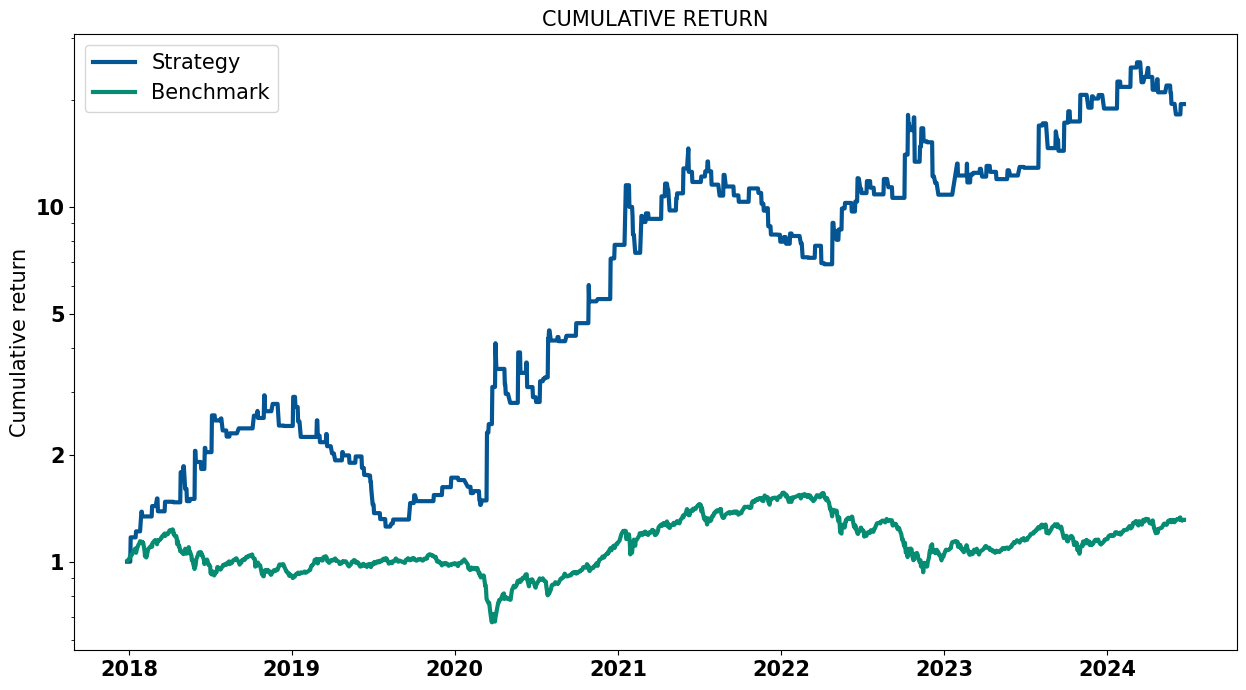

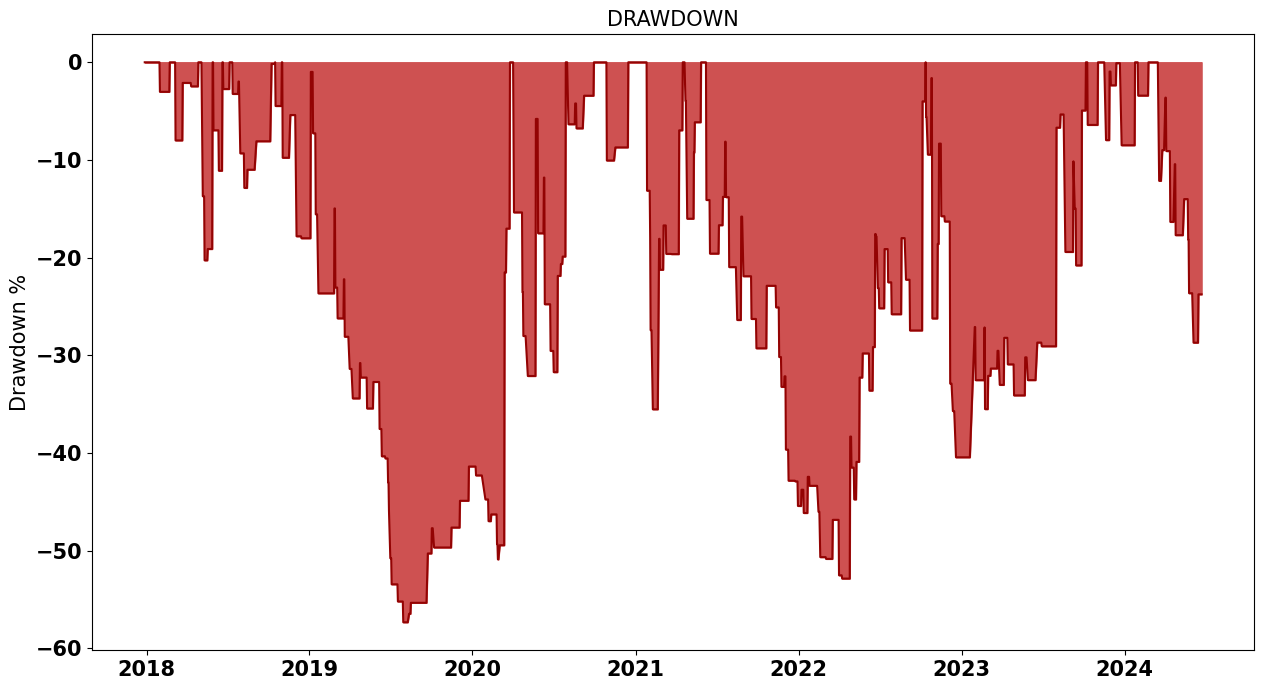

In [36]:
backtest_strategy(returns_all)

In [37]:
yearly_backtest(returns_all)

,Year,Return,Volatility,Sharpe,Max Drawdown,Beta,Alpha,Sortino,VaR,cVaR
0,2018,0.805274,0.362844,2.081537,-0.142917,-0.174805,0.852978,2.775410,0.046201,0.165517
1,2019,0.030986,0.332965,-0.057104,-0.288861,0.072684,0.022190,0.137202,0.744182,0.852773
2,2020,1.171200,0.530198,2.114682,-0.233364,-0.200382,1.171159,3.328862,0.070186,0.245911
3,2021,-0.078186,0.418051,-0.306628,-0.307542,0.067331,-0.084274,-0.286495,1.049051,1.194791
4,2022,0.695016,0.720490,0.895245,-0.306803,-0.108118,0.697059,1.411015,0.982467,1.233147
5,2023,0.592950,0.320981,1.691531,-0.089077,0.004746,0.592898,2.175240,0.150618,0.258896
6,2024,-0.036902,0.282962,-0.307116,-0.135581,0.021069,-0.050609,-0.141776,0.691445,0.786447


In [38]:
#Compute the correlation
returns_all1["Asset"].corr(returns_all2["Asset"])

0.13668606826576193

## Backtesting 5 Minutes Interval

In [148]:
#5 minute data
#Overall
asset_value = 1000  # 10B
prev_date = None
fee=0.001 #0.1% transaction fee
#Contract number
margin_call=0.17
initial_margin=0.27
cut_loss_max=10
# Strategy 1
cut_loss_thres_1 = .008
sma_window=132
bb_window=133
bb_std=1.41
vol_window=60
normal_margin_1=0.5
volatility_1=0.30
vol_target_1=False

#Strategy 2
cut_loss_thres_2 = .009
normal_margin_2=0.37
lookback_period=136
upbound=0.00264
downbound=-0
sma_window_2=6
volatility_2=.39
vol_target_2 = False
# Execute the trading strategy
weight_1=0.205
trading_data_is1 = minute5_is.copy()
trading_data_os1=minute5_os.copy()
trading_data_is2=minute5_is.copy()
trading_data_os2=minute5_os.copy()
trading_data_all1=minute5_data.copy()
trading_data_all2=minute5_data.copy()

In [149]:
# Execute for Strategy 1
result_is1, details_is1,asset_is1,holdings_is1, trade_records_is1 = execute_trading_strategy_1(
    trading_data_is1,bb_window,bb_std,sma_window,vol_window, asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)
result_os1, details_os1,asset_os1,holdings_os1, trade_records_os1 = execute_trading_strategy_1(trading_data_os1,bb_window,bb_std,sma_window,vol_window,
                                                                                                asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)
result_all1, details_all1,asset_all1,holdings_all1, trade_records_all1 = execute_trading_strategy_1(trading_data_all1,bb_window,bb_std,sma_window,vol_window,
                                                                                                    asset_value, cut_loss_thres_1,margincall=margin_call,initial_margin=initial_margin,normal_margin=normal_margin_1,volatility=volatility_1,vol_target=vol_target_1,cut_loss_max=cut_loss_max
)


In [150]:
#Execute for Strategy 2
result_is2, details_is2,asset_is2,holdings_is2, trade_records_is2 = execute_trading_strategy_2(
    trading_data_is2, lookback_period,upbound,downbound,sma_window_2, asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max)
result_os2, details_os2,asset_os2,holdings_os2, trade_records_os2 = execute_trading_strategy_2(trading_data_os2, lookback_period,upbound,downbound,sma_window_2,  asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max)
result_all2,details_all2,asset_all2,holdings_all2,trade_records_all2=execute_trading_strategy_2(
    trading_data_all2, lookback_period,upbound,downbound,sma_window_2, asset_value, cut_loss_thres_2,
    margin_call, initial_margin, normal_margin_2, volatility_2, vol_target_2,cut_loss_max=cut_loss_max) 

In [151]:
#Calculate the returns
returns_is1=pd.DataFrame(result_is1["Asset"].pct_change().dropna())
returns_os1=pd.DataFrame(result_os1["Asset"].pct_change().dropna())
returns_all1=pd.DataFrame(result_all1["Asset"].pct_change().dropna())
daily_returns_is1=returns_is1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
daily_returns_os1=returns_os1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
daily_returns_all1=returns_all1.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
#
returns_is2=pd.DataFrame(result_is2["Asset"].pct_change().dropna())
returns_os2=pd.DataFrame(result_os2["Asset"].pct_change().dropna())
returns_all2=pd.DataFrame(result_all2["Asset"].pct_change().dropna())
daily_returns_is2 = returns_is2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
daily_returns_os2 = returns_os2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
daily_returns_all2 = returns_all2.resample('D').apply(lambda x: (1 + x).prod() - 1).dropna()
#
#Combine the returns
daily_returns_is=daily_returns_is1*weight_1+daily_returns_is2*(1-weight_1)
daily_returns_os=daily_returns_os1.dropna()*weight_1+daily_returns_os2.dropna()*(1-weight_1)
daily_returns_all=daily_returns_all1*weight_1+daily_returns_all2*(1-weight_1)


    Annulized Return: 141.5% 	 Volatility: 44.11 %	     
    -----------------------------------------------------------------------------
    Beta: -0.261 	 Alpha: 140.88% 	 
    Sharpe: 3.094 	 Sortino: 4.638
    -----------------------------------------------------------------------------
    VaR: -37.92% 	 CVaR: -23.27% 	 
    VaR/cVaR: 0.614 	 Drawdown: 24.59%
    -----------------------------------------------------------------------------
    


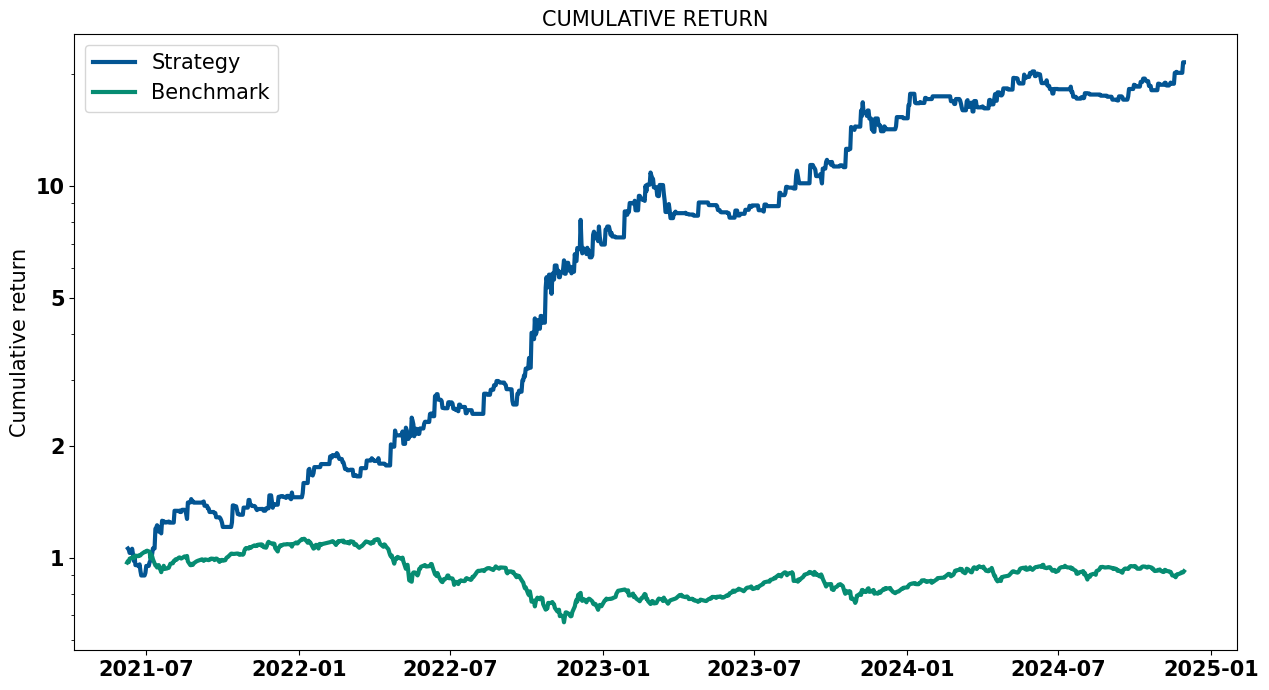

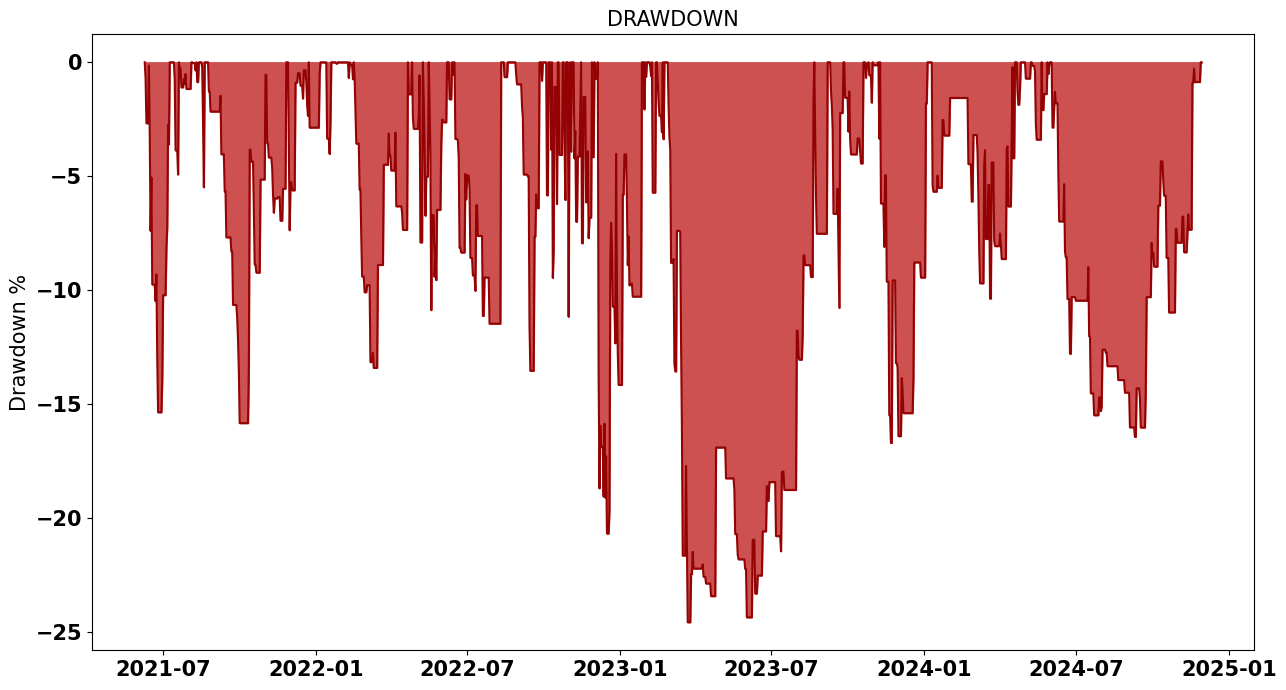

In [157]:
backtest_strategy(daily_returns_all)

In [158]:
yearly_backtest(returns_all)

,Year,Return,Volatility,Sharpe,Max Drawdown,Beta,Alpha,Sortino,VaR,cVaR
0,2018,0.805274,0.362844,2.081537,-0.142917,0.248273,0.883220,2.775410,0.041089,0.163020
1,2019,0.030986,0.332965,-0.057104,-0.288861,-0.075243,0.023416,0.137202,0.749583,0.859894
2,2020,1.171200,0.530198,2.114682,-0.233364,-0.523906,1.162991,3.328862,0.062293,0.250357
3,2021,-0.078186,0.418051,-0.306628,-0.307542,0.279087,-0.024686,-0.286495,1.052946,1.194878
4,2022,0.695016,0.720490,0.895245,-0.306803,0.143620,0.726276,1.411015,0.983516,1.223106
5,2023,0.592950,0.320981,1.691531,-0.089077,-0.239374,0.680840,2.175240,0.157134,0.266974
6,2024,-0.036902,0.282962,-0.307116,-0.135581,-0.080774,-0.055904,-0.141776,0.695260,0.790366


In [159]:
#Compute the correlation
daily_returns_all1["Asset"].corr(daily_returns_all2["Asset"])

0.3146398326222717